# Basic implementation using jupyter notebook

In [35]:
import logging, numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import cv2
import platform

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"





[2021-01-05 14:11:41,630] [INFO] [<module>] [11] : Starting ...


#### rotate image:

In [36]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2]  # image shape has 3 dimensions
    image_center = (
        width / 2,
        height / 2)  # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0, 0])
    abs_sin = abs(rotation_mat[0, 1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w / 2 - image_center[0]
    rotation_mat[1, 2] += bound_h / 2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat


### Parse roi:

In [37]:
def parse_roi(image):
    """
    Upon receiving an image, finds a face (if exists) and writes it as an image
    :param image: the image to be parsed
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # perform grayscale
    flag_face_detected = False
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    face = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )
    for (x, y, w, h) in face:
        flag_face_detected = True
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi_color = image[y:y + h, x:x + w]
        # print("[INFO] Object found. Saving locally.")
        cv2.imwrite('faces_detected.jpg', roi_color)
        roi_color_rgb = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
        # plt.imshow(roi_color_rgb)
        # plt.show()
    if not flag_face_detected:
        logging.warning("No face detected in image")

#### Plot results:

In [38]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    x_value = x_value.reshape(1, x_value.shape[0])
    r = reds.tolist()[0]
    b = blues.tolist()[0]
    g = greens.tolist()[0]
    x = x_value.tolist()[0]
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x, g, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x, r, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x, b, color="blue")
    plt.show()
    logging.info("Showing result")

### calculate mean:

In [39]:
def parse_RGB(image, vidcap, greens, reds, blues, frame_number):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
    blue, green, red = cv2.split(image)
    greens[0, frame_number] = np.mean(green)
    blues[0, frame_number] = np.mean(blue)
    reds[0, frame_number] = np.mean(red)
    success, image = vidcap.read()
    return success, image

### read video frames

In [40]:
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test.mp4"
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
# image = cv2.rotate(image, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
fps = vidcap.get(cv2.CAP_PROP_FPS)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
x_value = np.arange((number_of_frames / np.round(fps)), step=(1 / 30))
greens = np.zeros((1, int(number_of_frames)))  # instead of lists
reds = np.zeros((1, int(number_of_frames)))
blues = np.zeros((1, int(number_of_frames)))
frame_number = 0
logging.info("Parsing images ...")
while success:
    # image = rotate_image(image, 90)
    parse_roi(image)  # build image ROI
    image = cv2.imread("faces_detected.jpg") # possible BUG: read the same image twice if face not detected.
    success, image = parse_RGB(image, vidcap, greens, reds, blues, frame_number)
    frame_number += 1
    # image = cv2.rotate(image, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    # cv2.imshow("Rotated (Correct)", image)

[2021-01-05 14:11:41,730] [INFO] [<module>] [5] : Working on video ..\dataset\good_sync\perry-all-2\test.mp4
[2021-01-05 14:11:41,848] [INFO] [<module>] [16] : Parsing images ...
[2021-01-05 14:12:20,933] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,021] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,115] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,198] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,281] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,377] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,475] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,570] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,681] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05 14:12:21,794] [WARNING] [parse_roi] [27] : No face detected in image
[2021-01-05

### Butter filter:

In [41]:
def apply_butter_filter(sig,fs):
    """
    Filter signal using Butter filter and filtfilt. 
    :param sig: is the signal to be filtered
    :return: the filtered signal
    """
    logging.info("Applying butter filter...")
    # NOTE: 4 is the order,filternig valuesshould be between 0 to 1,
    #Hence we multiply the freq. by 2 and divide by fs witch is the fps of the video.
    bh,ah = signal.butter(4,4*2/fs,btype='highpass') # high pass at 4 hz Coefficients 
    bl,al = signal.butter(4,2/fs,btype='lowpass') # low pass at 1 hz  Coefficients
    sig = signal.filtfilt(bh,ah,sig) # applying the filter coefficients on the signal.
    sig = np.absolute(sig)
    sig = signal.filtfilt(bl,al,sig)
    return sig 



### Plot after butter filter and the original signals ( A sanity check)

[2021-01-05 14:12:55,806] [INFO] [plot_result] [3] : Plotting results ...All 3 channels
[2021-01-05 14:12:56,433] [INFO] [plot_result] [20] : Showing result
[2021-01-05 14:12:56,434] [INFO] [apply_butter_filter] [8] : Applying butter filter...
[2021-01-05 14:12:56,507] [INFO] [apply_butter_filter] [8] : Applying butter filter...
[2021-01-05 14:12:56,511] [INFO] [apply_butter_filter] [8] : Applying butter filter...
[2021-01-05 14:12:56,983] [INFO] [<module>] [18] : Finished parsing the video.


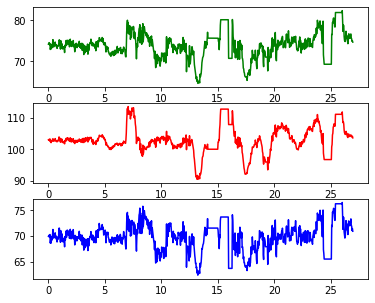

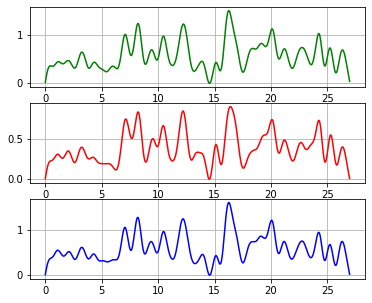

In [42]:
plot_result(greens, reds, blues, x_value, "All 3 channels") # original signals
greens_buttered = apply_butter_filter(greens,fs=fps)
blues_buttered = apply_butter_filter(blues,fs=fps)
reds_buttered = apply_butter_filter(reds,fs=fps)
plt.figure(figsize=(6, 5))
plt.title("After filter")
plt.subplot(3,1,1)
plt.plot(x_value.tolist(), greens_buttered.tolist()[0], color="green")
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(x_value.tolist(), reds_buttered.tolist()[0], color="red")
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(x_value.tolist(), blues_buttered.tolist()[0], color="blue")
plt.grid(True)
plt.show()
logging.info("Finished parsing the video.")

